<font size=6> <b> 7 주차 강의 Notebook </b> </font>
<div class="alert alert-block alert-success">
  Time-Series 데이터를 다루기 위한 기본 지식과 이를 기반으로 주가 정보를 예측해 보자!<br>
</div>
</div>

<p style="text-align:right;"> sumyeon@gmail.com </p>


<hr>

- 6주차 강의에 이어지는 내용으로, 이하는 6주차 주요 내용 요약

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime
import pandas_datareader.data as pdrdata
from tqdm.notebook import tqdm

%matplotlib inline

> 한글 폰트 로딩

In [2]:
import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname='C:\\WINDOWS\\Fonts\\HYWULM.TTF').get_name()
plt.rc('font', family=font_name)

> 메타 데이터 로딩 및 dict 구성

In [3]:
metadf = pd.read_csv("krxstockdata.csv", dtype={"종목코드":str})

meta2df = pd.read_csv("etfitemdata.csv", sep="\t")

meta2df['종목코드'] = meta2df['종목코드'].map(lambda x : x[1:])

name2code_dict = dict(zip( metadf['기업명'].values, metadf['종목코드'].values))
code2name_dict = dict(zip( metadf['종목코드'].values, metadf['기업명'].values))

name2code_dict.update(dict(zip( meta2df['종목명'].values, meta2df['종목코드'].values)) )
code2name_dict.update(dict(zip( meta2df['종목코드'].values, meta2df['종목명'].values)))

> 회사별 주식 정보를 로딩 함수

In [4]:
def getStockHistory(companylist, start='2018-01-01', end=datetime.datetime.now().strftime('%Y-%m-%d')):
    """
    return the stock histories of the companies given
    
    Parameters:
        companylist : list - list of company names or codes 
        start       : Str - start date string
        end         : Str - end date string
        
    Returns:
        list : list of stock history data frame
    """
    
    if isinstance(companylist[0], str) and not companylist[0].isnumeric():
        companylist = [name2code_dict[name] for name in companylist]
    
    dflist = [pdrdata.DataReader(code, 'naver', start, end) for code in companylist]
    dflist2 = [df.apply(pd.to_numeric) for df in dflist]
    
    for idx, code in enumerate(companylist):
        dflist2[idx]['name'] = code2name_dict[code]      # index에 회사명을 추가
        dflist2[idx] = dflist2[idx].set_index('name', append=True).unstack()   # index의 회사명을 column으로 보내기
        dflist2[idx] = dflist2[idx].swaplevel(0,1,1)
    return pd.concat(dflist2, axis=1)

> 업종별 회사 리스트 

In [5]:
def get_cclist_by_subject(subject):
    cclist = metadf[metadf['업종'] == subject]['종목코드'].values
    if len(cclist) == 0:
        raise ValueError("없는 업종")
        
    return cclist

In [6]:
get_cclist_by_subject('의료용품 및 기타 의약 관련제품 제조업')

array(['138610', '142280', '343090', '233250', '059210', '206640',
       '064550', '100700', '253840', '096530', '246720', '260660',
       '174900', '950130', '153710', '278380', '246960', '086890',
       '216080', '229000', '228760', '046210', '303360', '241820',
       '042520', '205470'], dtype=object)

> Widget을 이용 주식 챠트 그려주는 함수

In [7]:
import ipywidgets as widgets

def draw_chart(name_list, date_range, values):
    """
    
    """
    fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
    stockdf = getStockHistory([name_list], date_range[0].strftime("%Y-%m-%d"), date_range[1].strftime("%Y-%m-%d"))
    stockdf = stockdf.droplevel(0, axis=1)
    stockdf[list(values)].plot(ax=ax)
    #plt.scatter(stockdf.index, targetdf['Close'], color='Black')

start_date = datetime.datetime(2019, 1, 1)
end_date = datetime.datetime.now().date()
dates = pd.date_range(start_date, end_date, freq='D')

options = [(date.strftime(' %Y-%m-%d '), date) for date in dates]
index = (0, len(options)-1)

selection_range_slider = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Dates',
    orientation='horizontal',
    layout={'width': '500px'}
)

selection_values = widgets.SelectMultiple(
    options=['Open','Close','High','Low'],
    value=['Close'],
    description='Values',
    disabled=False
)

widgets.interact(draw_chart, name_list = name2code_dict.keys(), date_range=selection_range_slider, values=selection_values)

interactive(children=(Dropdown(description='name_list', options=('3S', 'AJ네트웍스', 'AK홀딩스', 'APS홀딩스', 'AP시스템', '…

<function __main__.draw_chart(name_list, date_range, values)>

> 주가 투자 알고리즘 성능 평가 함수

In [8]:
def measure_gains(tdf, invest_list, total_money=5_000_000, commision_perc=5):
    
    invest_money = total_money
    tdf= tdf.resample('D').fillna('ffill')
    tdf = tdf.droplevel(0, axis=1)
    for [sdate,edate] in invest_list:
        sdate_price = tdf.loc[sdate, 'Close']
        stock_amount = invest_money // sdate_price
        remain_money = invest_money - stock_amount * sdate_price
        edate_price = tdf.loc[edate, 'Close']
        invest_money = stock_amount * edate_price * (100-commision_perc)/100 + remain_money
        
    return invest_money / total_money * 100

> 비교 (레퍼런스) 알고리즘 : optimal

In [9]:
def realistic_optimal(targetdf, min_investdays=3):
    
    targetdf= targetdf.resample('D').fillna('ffill')
    tdf = targetdf.droplevel(0, axis=1)
    tdf = tdf[['Close']]
    tdf['tomorrow_gap'] = tdf['Close'].shift(-1) - tdf['Close'] 
    tdf['tomorrow_ratio'] = tdf['tomorrow_gap'] / tdf['Close'] * 100
    
    invest_list = []
    during_invest = False
    for rows in tdf.itertuples():
        if rows[2] < 0 and during_invest:
            invest.append(rows[0])  # set today as end date of invest
            during_invest = False
            if (invest[1] - invest[0]).days >= min_investdays:
                invest_list.append(invest)
        elif rows[2] < 0 and not during_invest:
            continue
        elif rows[2] > 0 and during_invest:
            continue
        elif rows[2] > 0 and not during_invest:
            invest = [rows[0]]
            during_invest = True
            
    return invest_list

> 투자 알고리즘 visualization 함수

In [10]:
import matplotlib
matplotlib.style.use('ggplot')

In [11]:
def visualize_invest(targetdf, invest_list):
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
    
    # draw whole graph
    targetdf= targetdf.resample('D').fillna('ffill')
    tdf = targetdf.droplevel(0,1)
    tdf = tdf[['Close']]
    tdf['Close'].plot(ax=ax, color='yellow', linewidth=3)
    
    #plt.scatter(targetdf.index, targetdf['Close'], color='Black')
    
    
    #draw invest graph
    for [sdate,edate] in invest_list:
        tdf.loc[sdate:edate,'Close'].plot(ax=ax, color='red', linewidth=2)

        

<hr>

# Sample Data

- 예제로 사용할 회사 주가 정보 준비

In [14]:
stockdf = getStockHistory(["삼성전자"], start='2019-01-01')
stock2df = stockdf.droplevel(0,axis=1)
stock2df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,39400,39400,38550,38750,7847664
2019-01-03,38300,38550,37450,37600,12471493
2019-01-04,37450,37600,36850,37450,14108958
2019-01-07,38000,38900,37800,38750,12748997
2019-01-08,38000,39200,37950,38100,12756554


<hr>

# Time Series 데이터 분석 개요

## Time Series 분석에 대해 소개 글 중 좋은 내용 모음 <br>

SARIMA timeseries prediction
The best explanation and comparison on many kinds of timeseries prediction
https://towardsdatascience.com/arima-sarima-vs-lstm-with-ensemble-learning-insights-for-time-series-data-509a5d87f20a

step by step guide
https://towardsdatascience.com/end-to-end-time-series-analysis-and-modelling-8c34f09a3014

Identifying the optimal parameter for AR/MA terms
https://people.duke.edu/~rnau/411arim3.htm

detailed explanation
https://towardsdatascience.com/almost-everything-you-need-to-know-about-time-series-860241bdc578

best explanation
https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3

Sesonality working in Triple Explonetial Smoothing (Charles Holt and his student Peter Winters)
https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm

LSTM article
https://medium.com/swlh/a-quick-example-of-time-series-forecasting-using-long-short-term-memory-lstm-networks-ddc10dc1467d

## Time Series 데이터 분석 개요 <br>

-  Time Series (시계열) 분석의 대부분의 경우 미래 트렌드를 예측함으로써 문제를 해결할 수 있는 경우가 많음 <br>
예를 들어, 주가 예측, 판매 예측 등의 경우 당연하게 정확한 예측이 필요한 문제이며 Outlier detection과 같은 <br>
이벤트 디텍션의 경우도 대부분 해당 지점의 (정확한) 예측값과 실제 값의 차이가 예외적인 경우를 찾아서 해결함 <br> 

=> 결국, 미래 데이터를 예측하는 이슈가 가장 핵심 이슈임

- 미래 트렌드를 예측하기 위해서는, 미래 트렌드를 예측하는데 필요한 hint가 있어야 하는데 대부분의 경우 <br>
가장 중요한 hint는 과거 트렌드임. 즉, 과거 이력을 가지고 다음 단계를 예측하는게 일반적인 방법임 <br>


=> Univariate Time Series Forecasting vs. Multivariate Time Series Forecasting <br>
=> 과거 데이터를 이용한 미래 예측 방법은?

- 과거 데이터를 이용하는 기본적인 아이디어는 다음과 같다

1) Moving Average : 과거 데이터들의 평균 값으로 미래 값을 결정
  - weighted moving average, exponential (weighted) moving average 등 다양한 방식 존재
  
2) Auto Regression : 과거 데이터들을 인자로 하는 (linear regression) 함수로 미래 값을 결정
  - 1차, 2차, .... , n차 모델등 다양한 방식의 모델이 존재


## Raw Data

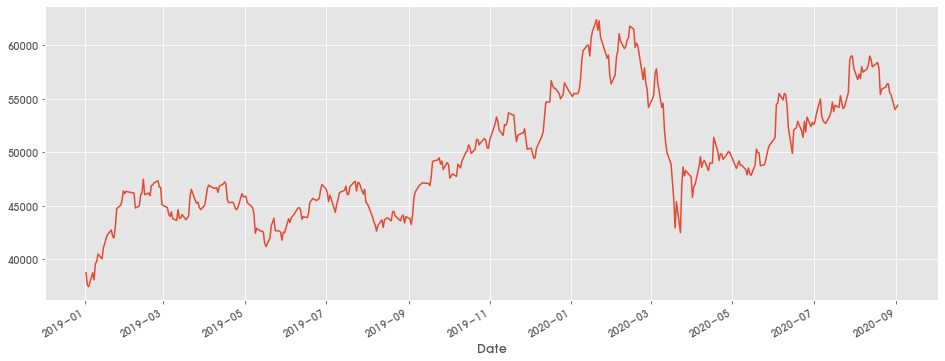

In [50]:
ax = stock2df['Close'].plot(figsize=(16,6))
#plt.scatter(stock2df.index, stock2df['Close'], color='Black')

## Moving Average

In [66]:
from sklearn.metrics import mean_absolute_error

### Moving Average (Rolling Window)

In [63]:
def plot_moving_average(series, window, plot_intervals=True, scale=1.96):
    
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(16,6))
    plt.title(f"Moving average window size = {window}")
    plt.plot(rolling_mean, 'g', label='rolling mean trend')
    
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--',label = 'Upper bound/ Lower bound')
        plt.plot(lower_bound, 'r--')
        
    plt.plot(series[window:], label = 'Actual Values')
    plt.legend(loc='best')
    plt.grid(True)

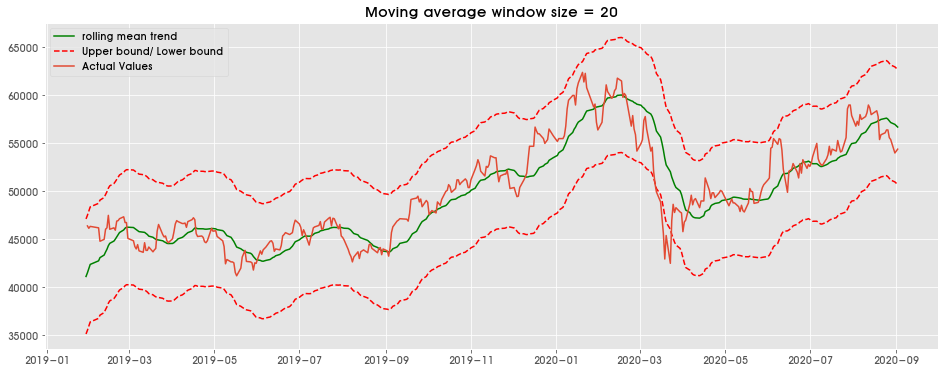

In [64]:
plot_moving_average(stock2df['Close'],20)

### Exponential Smoothing

In [61]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1-alpha)*result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    
    plt.figure(figsize=(16,6))
    for alpha in alphas:
        plt.plot( exponential_smoothing(series, alpha), label =f"Alpha{alpha}")
    plt.plot(series.values, "c", label = 'Actual')
    plt.legend(loc='best')
    plt.axis('tight')
    plt.title('Exponential Smoothing')
    plt.grid(True)

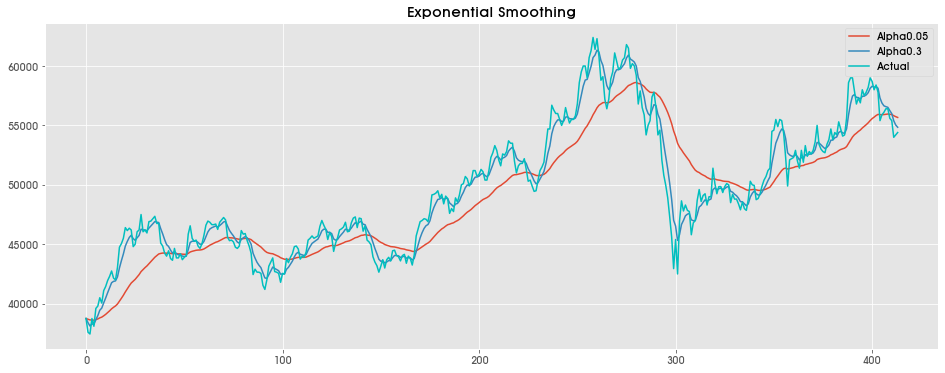

In [62]:
plot_exponential_smoothing(stock2df['Close'], [0.05, 0.3])

## Auto Regression

In [65]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

### 15개 과거 데이터를 이용해서 미래를 예측

In [76]:
model = AutoReg(stock2df['Close'], lags=15)
model_fit = model.fit()

In [77]:
reg_result = model_fit.predict()

### Fitting된 결과

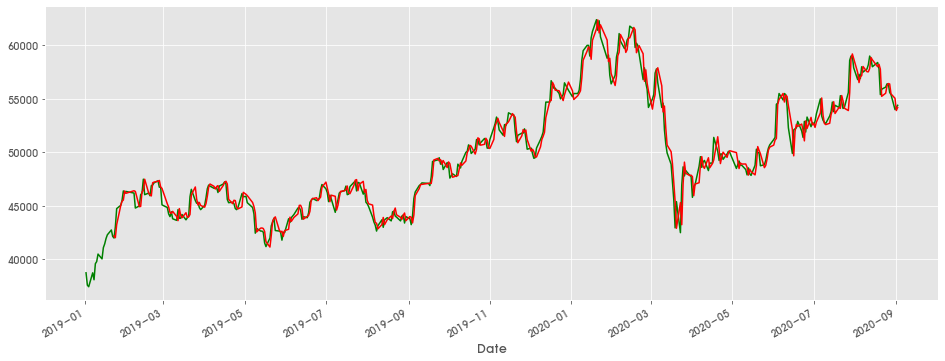

In [81]:
fig,ax = plt.subplots(figsize=(16,6))
stock2df['Close'].plot(color='green', ax=ax)
ax.plot(stock2df.index, reg_result, color='red')

In [83]:
print('Coefficients: %s' % model_fit.params)

Coefficients: intercept    892.715681
Close.L1       1.003727
Close.L2       0.093579
Close.L3      -0.138234
Close.L4      -0.055455
Close.L5       0.069469
Close.L6      -0.004374
Close.L7       0.063766
Close.L8      -0.021516
Close.L9      -0.048268
Close.L10      0.013290
Close.L11     -0.009636
Close.L12     -0.011037
Close.L13      0.009225
Close.L14      0.070001
Close.L15     -0.051844
dtype: float64


### 365개 데이터를 기반으로 하루씩 Regression 예측값을 구해보자

In [90]:
X = stock2df['Close']
size = 365

train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = AutoReg(history, lags=15)
    model_fit = model.fit()
    forecast = model_fit.predict(len(history), len(history))
    predictions.append(forecast[0])
    obs = test[t]
    history.append(obs)
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 896727.890


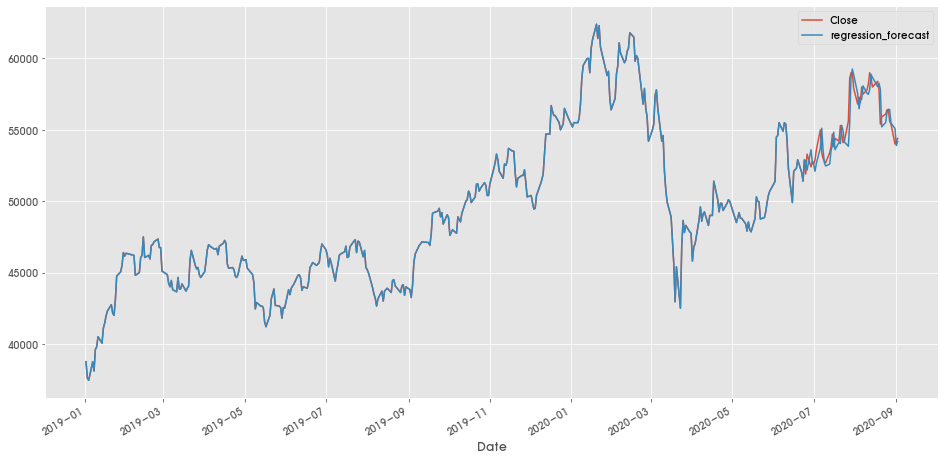

In [92]:
stock2df['regression_forecast'] = list(X[0:size].values) +  predictions
fig,ax = plt.subplots(figsize=(16,8))
stock2df[['Close','regression_forecast']].plot(ax=ax)
plt.show()

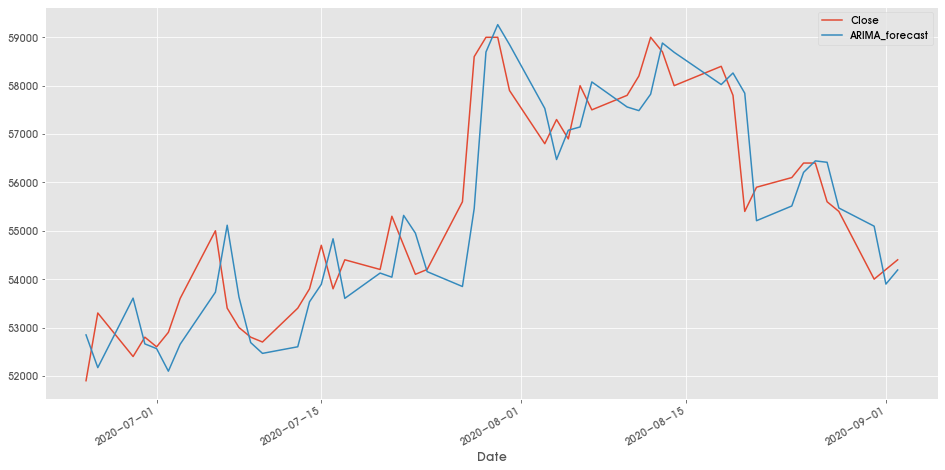

In [93]:
stock2df['ARIMA_forecast'] = list(X[0:size].values) +  predictions
fig,ax = plt.subplots(figsize=(16,8))
stock2df[365:][['Close','ARIMA_forecast']].plot(ax=ax)
plt.show()

- Moving Average, Regression을 함께 사용해서 예측하는 방법 존재! (ARMA)

 
=> 그런데, 예측을 위해서 Moving Average는 과거 몇 개까지 고려? Regression은 과거 몇 개까지 고려해야 하는지?

## Box-Jenkins Method

- 위와 같은 질문에 대한 답을 찾아주는 Box-Jenkins Method라는 정형화된 procedure가 존재한다. <br>
 
  
<img src="https://www.researchgate.net/profile/Nikolaos_Dritsakis/publication/324889402/figure/fig1/AS:621748022149122@1525247688372/Schematic-representation-of-the-Box-Jenkins-methodology-for-time-series-modeling.png"  width="500"> 

- 참고 1) Time Series 분석을 위한 AR/MA 최적 parameter를 찾을때 Stationary한 상태에서 효과가 좋음
> Stationary : 데이터가 전체 기간에 걸쳐 mean, variance가 일정한 상태 <br>
> Dickey-Muller 테스트나 ACF/PACF 도표를 통해 Stationary 여부 확인 <br>
> Stationary하지 않은 경우, differncing을 통해 stationary 상태로 변경 후 진행

# 실제 적용

- Box-Jenkins Method를 따라 Scikit-Learn의 ARIMA 모델을 적용해 본다
> ARIMA : AR (Auto Regression) - I (Integrated - adopt differencing) - MA (Moving Average)

## 필요한 패키지 import

In [12]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

## Warning Message 무시 

- Time Series 분석 과정에서 Warning Message가 발생, 이를 무시하는 utility 코드

In [13]:
import warnings

warnings.filterwarnings("ignore")

## Check/Make the data stationary and get the hints on how many days we have to look back for best predicion


### Dickey-Fuller Test와 ACF/PACF 그래프를 확인하는 함수

In [16]:
def tsplot(y, lags=None, figsize=(12,7), style='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style=style):    # plt.style.use(style)과 동일한 효과이나 context 내에서만 효력이 발생
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)  # 0,0 위치에 column 길이 2개짜리 그래프 
        acf_ax = plt.subplot2grid(layout, (1,0))            # 1,0 위치에 그래프
        pacf_ax = plt.subplot2grid(layout, (1,1))           # 1,1, 위치에 그래프
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]           # Dickey Fuller 테스트 수행 후 p-value만 확인
        ts_ax.set_title(f"Time Series Analysis Plots \n Dickey-Fuller: p={p_value:.5f}")
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
 

<div class="alert alert-block alert-info">
<b> Tip:</b> 앞서 plt.style.use('ggplot')을 통해, 전체 그래프 style을 바꿀 수도 있었는데, with plt.style.context(style=style)은 현재
    context내에서만 해당 효력을 발휘 <br>
</div>

### tsplot함수를 통해, Dickey-Fuller, ACF, PACF 모두를 확인해 보자

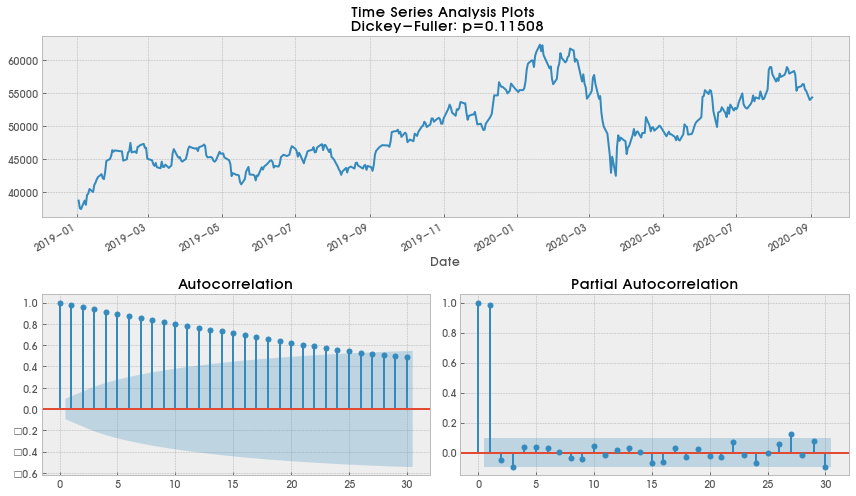

In [17]:
tsplot(stock2df['Close'], lags=30)        

### 아직 Stationary하지 않으므로 Differencing을 적용해 보자
> Difference Data :  Data - Data.shift(1)

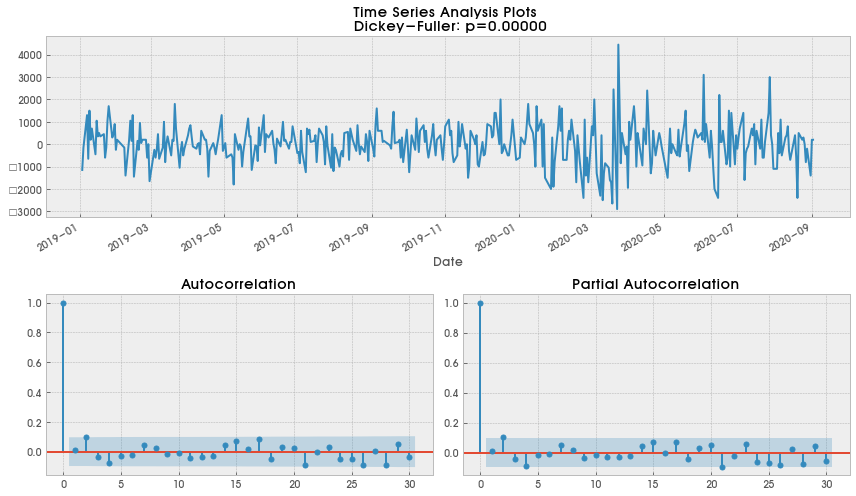

In [18]:
stock2df_diff = stock2df['Close'] - stock2df['Close'].shift(1)
tsplot(stock2df_diff[1:], lags=30)

Dickey-Fuller의 p-value가 95%, 99% 밖에 위치하므로 stock_diff는 stationary하다고 말할 수 있다.  <br>
이때, Partial Autocorrelation, Autocorrelation 모두 0개 (자기 자신)의 과거 데이터를 참조하는 것으로 나타난다. <br>
<= AR/MA의 최적의 parameter값이 큰 의미가 없는 상황임

## 모델을 만들고 fiting 시켜 보자

In [19]:
model = ARIMA(stock2df['Close'], order=(2, 1,2))

<div class="alert alert-block alert-info">
<b> Tip:</b> order=(p,d,q) <br>
  -  <b> p : </b> the number of lag observations included in this model. <br>
  -  <b> d : </b> the number of times that the raw observations are differenced, also called the degree of differencing <br>
  -  <b> q : </b> the size of moving average window, also called the order of moving average <br> 
</div>

In [20]:
model_fit = model.fit()

### Fiting된 모델 평가

In [20]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  413
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3384.415
Date:                Tue, 01 Sep 2020   AIC                           6778.831
Time:                        22:04:08   BIC                           6798.936
Sample:                             0   HQIC                          6786.783
                                - 413                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0912      0.330     -0.277      0.782      -0.738       0.555
ar.L2         -0.4651      0.402     -1.156      0.248      -1.254       0.324
ma.L1          0.0645      0.316      0.204      0.8

### Fitting 값과 orginal 값 비교

In [21]:
predict = model_fit.predict(typ='levels')
stock2df['ARIMA_fit'] = predict

<AxesSubplot:xlabel='Date'>

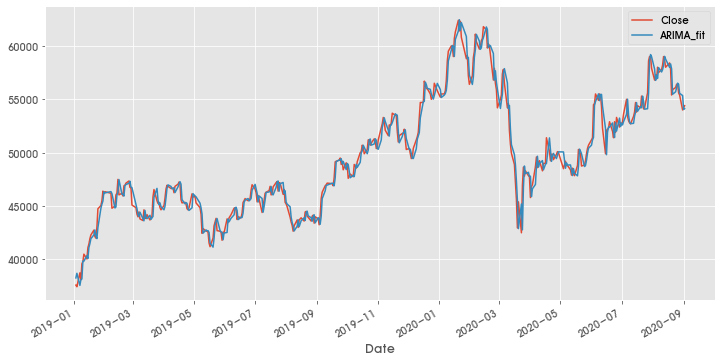

In [23]:
stock2df[1:][['Close','ARIMA_fit']].plot(figsize=(12,6))

<div class="alert alert-block alert-warning">
<b> 위의 그래프는, 전체 데이터에 대해서 ARIMA fit 함수가 얼마나 fit되는가를 보여준다. <br>
    실제 prediction이 잘 되는지를 확인하기 위해서는 rolling window형태로 미래 값을 예측해야 한다.
</div>

### Redisuals의 분포 점검 : 모델링의 성공 여부 평가

<AxesSubplot:ylabel='Density'>

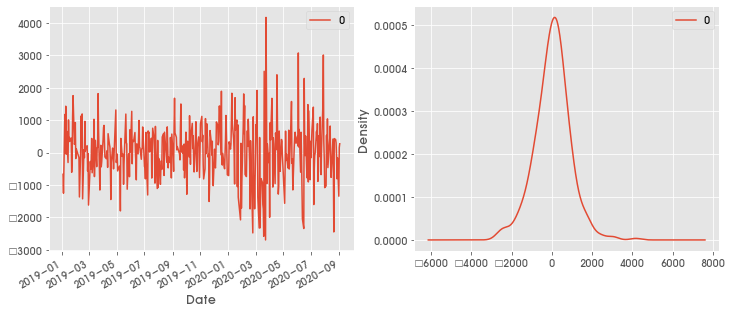

In [24]:
#plot residual errors
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
residuals = pd.DataFrame(model_fit.resid[1:])
residuals.plot(ax=ax[0])
residuals.plot(kind='kde', ax=ax[1])

## Rolling window 형태로 과거 데이터를 가지고 예측값을 확인해 보자

과거 1년치 ( 2018-01-01 ~ 2019-12-31) 데이터를 기본 train 데이터로 사용하고, 하루치씩 predict 해보자

In [25]:
X = stock2df['Close']
size = 365
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(2,1,2))
	model_fit = model.fit()
	forecast_vals = model_fit.forecast()
	predictions.append(forecast_vals[0])
	obs = test[t]
	history.append(obs)
	#print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot

Test MSE: 810120.137


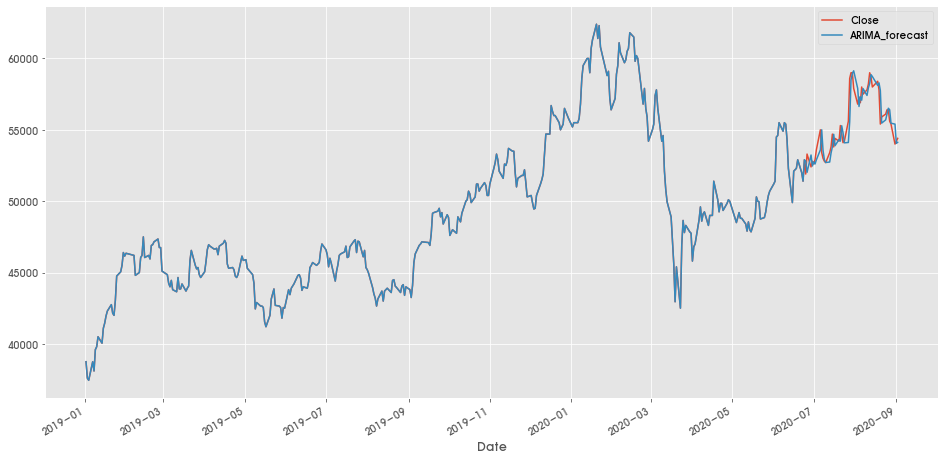

In [26]:
stock2df['ARIMA_forecast'] = list(X[0:size].values) +  predictions
fig,ax = plt.subplots(figsize=(16,8))
stock2df[['Close','ARIMA_forecast']].plot(ax=ax)
plt.show()

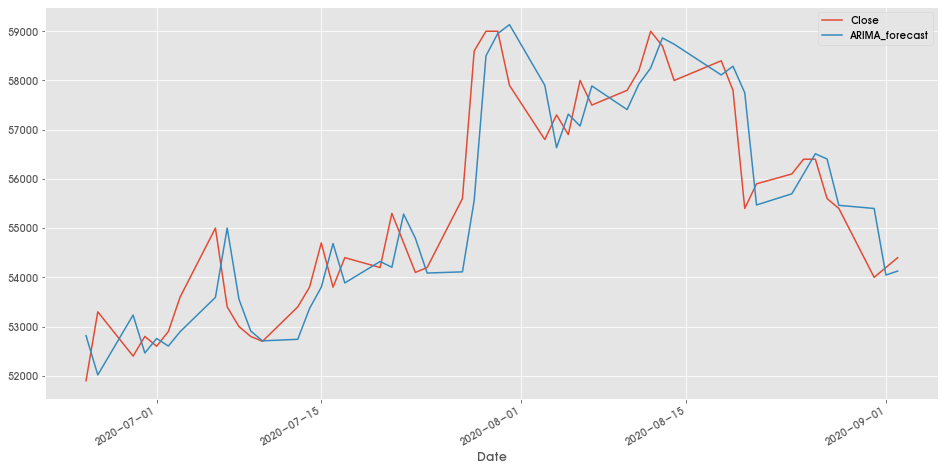

In [27]:
stock2df['ARIMA_forecast'] = list(X[0:size].values) +  predictions
fig,ax = plt.subplots(figsize=(16,8))
stock2df[365:][['Close','ARIMA_forecast']].plot(ax=ax)
plt.show()

<div class="alert alert-block alert-warning">
<b> ARIMA를 통한 forecast가 주가를 잘 따르는 것으로 보일 수도 있지만, 자세히 보면 다음날 주가의 등/락을 반대로 예측하는 경우가 있음
</div>

# ARIMA 모델을 적용한 주식 투자 모델을 만들어 보자

- 지난 시간의, referenc 투자 모델은, <br>
주식 시세를 따라가면서 주가가 3일 연속 증가할 것으로 예측되면 매수를, 바로 다음날 하락이 예상되면 매도를 한다! <br> <br>

- ARIMA 모델은, reference 투자 모델과 동일한 로직임 but 실제 값을 보는 것이 아니라 ARIMA_forecast 값을 바탕으로 결정을 내림

- 참고) ARIMA model의 forecast 함수를 활용. steps=N argument를 통해 N 개의 미래값을 예측 <br>

<pre>
> model_fit.forecast()

 (array([55294.68990393]),
  array([890.62055012]),
  array([[53549.1057018 , 57040.27410607]]))
  
> model_fit.forecast(steps=3)
  
  (array([55294.68990393, 55343.84432012, 55453.14801439]),
   array([ 890.62055012, 1274.08945967, 1624.80512165]),
   array([[53549.1057018 , 57040.27410607],
        [52846.67486608, 57841.01377416],
        [52268.58849406, 58637.70753471]]))
</pre>

## 샘플용 데이터 확보

In [28]:
stockdf = getStockHistory(["삼성전자"], start='2019-01-01')

## ARIMA Rolling Window Fit 알고리즘을 활용한 투자 함수

In [29]:
def arima_rolling_window_invest(targetdf, min_investdays=3):
    
    tdf = targetdf.droplevel(0, axis=1)
    tdf = tdf[['Close']]   
    invest_list = []
    during_invest = False
    
    train = tdf.loc[:datetime.datetime(2020,1,1), 'Close']
    test = tdf.loc[datetime.datetime(2020,1,1):, 'Close']
    history = [ x for x in train]

    for t in tqdm(range(len(test))):
        model = ARIMA(history, order=(2,1,2))
        model_fit = model.fit()
        forecast_vals = model_fit.forecast(steps=min_investdays)
        
        
        obs = test[t]
        base_forecast = np.insert(forecast_vals, 0, obs)
        history.append(obs)
        #print(base_forecast)

        if during_invest and ((base_forecast[1] < base_forecast[0]) or (base_forecast[0] < buy_price)):
            invest.append(test.index[t])  # set today as end date of invest
            during_invest = False
            invest_list.append(invest)
            #print("--", base_forecast, test.index[t])
        elif base_forecast[1] < base_forecast[0] and not during_invest:
            continue
        elif base_forecast[1] - base_forecast[0] > 0 and during_invest:
            continue
        elif np.all(np.diff(base_forecast) > 0) and not during_invest:
            invest = [test.index[t]]
            during_invest = True
            buy_price = obs
            buy_index = t
            #print("++", base_forecast, test.index[t])
            
    return invest_list

## 투자 예측 결과

In [30]:
invest_list = arima_rolling_window_invest(stockdf, 3)

In [31]:
invest_list

[[Timestamp('2020-01-15 00:00:00'), Timestamp('2020-01-16 00:00:00')],
 [Timestamp('2020-02-24 00:00:00'), Timestamp('2020-02-25 00:00:00')],
 [Timestamp('2020-03-11 00:00:00'), Timestamp('2020-03-12 00:00:00')],
 [Timestamp('2020-03-13 00:00:00'), Timestamp('2020-03-16 00:00:00')],
 [Timestamp('2020-03-17 00:00:00'), Timestamp('2020-03-18 00:00:00')],
 [Timestamp('2020-03-23 00:00:00'), Timestamp('2020-03-24 00:00:00')],
 [Timestamp('2020-04-20 00:00:00'), Timestamp('2020-04-21 00:00:00')],
 [Timestamp('2020-04-24 00:00:00'), Timestamp('2020-04-27 00:00:00')],
 [Timestamp('2020-04-29 00:00:00'), Timestamp('2020-05-04 00:00:00')],
 [Timestamp('2020-05-14 00:00:00'), Timestamp('2020-05-15 00:00:00')],
 [Timestamp('2020-05-20 00:00:00'), Timestamp('2020-05-21 00:00:00')],
 [Timestamp('2020-06-10 00:00:00'), Timestamp('2020-06-11 00:00:00')],
 [Timestamp('2020-06-25 00:00:00'), Timestamp('2020-06-26 00:00:00')],
 [Timestamp('2020-06-29 00:00:00'), Timestamp('2020-06-30 00:00:00')],
 [Time

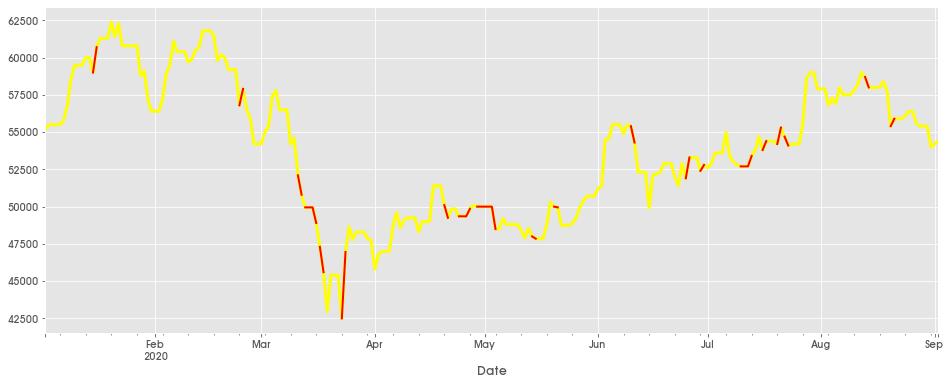

In [32]:
visualize_invest(stockdf[datetime.datetime(2019,12,31):], invest_list)

## Reference 투자 알고리즘과 비교

In [33]:
measure_gains(stockdf, invest_list)

38.6962

In [34]:
measure_gains(stockdf, realistic_optimal(stockdf.loc[datetime.datetime(2019,12,31):]) )

100.2653

<div class="alert alert-block alert-warning">
<b> 2020-01-01 부터 38% 수익률로 나쁘지 않은 것 처럼 보이나, 3월말 투자시에 급증한 부분을 제외하고는 마이너스 상황도 많다
</div>

<img src="https://miro.medium.com/max/517/1*9xhiP7nD8Ur2c3nrnApQkQ.jpeg">

# Hyper-parameter Tuning

<b> 앞서 빠른 진행을 위해 ARIMA의 hyper-parameter (p,d,q)를 (2,1,2)로 random 선택 했으나, <br>
    최고의 성능을 위해서는 최적의 hyper-parameter를 찾는 작업이 필요 <b>
    
https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/    

## Data Loading

In [35]:
stockdf = getStockHistory(["삼성전자"], start='2019-01-01')
stock2df = stockdf.droplevel(0,axis=1)
stock2df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,39400,39400,38550,38750,7847664
2019-01-03,38300,38550,37450,37600,12471493
2019-01-04,37450,37600,36850,37450,14108958
2019-01-07,38000,38900,37800,38750,12748997
2019-01-08,38000,39200,37950,38100,12756554


## ARIMA 모델 평가하는 함수 

In [36]:
def evaluate_arima_model(X, hyperparam):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=hyperparam)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

## 다양한 조건의 hyper-parameter 적용 테스트

In [37]:
from itertools import product

p_values = range(0,3)
d_values = [1]
q_values = [0,1,2]

In [38]:
list(product(p_values,d_values,q_values))

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2)]

In [39]:
def evaluate_models(X, p_values, d_values, q_values):
    
    best_score, best_cfg = float("inf"), None

    for hyper_param in product(p_values,d_values,q_values):
        try:
            print(hyper_param)
            mse = evaluate_arima_model(X, hyper_param)
            if mse < best_score:
                best_score, best_cfg = mse, hyper_param
            print(f"ARIMA{hyper_param} MSE={mse:.3f}")
        except:
            continue
    print(f"Best ARIMA{best_cfg} and MSE={best_score:.3f} ")

In [41]:
evaluate_models(stock2df['Close'], p_values, d_values, q_values)

(0, 1, 0)
ARIMA(0, 1, 0) MSE=1357695.035
(0, 1, 1)
ARIMA(0, 1, 1) MSE=1362427.896
(0, 1, 2)
ARIMA(0, 1, 2) MSE=1354396.240
(1, 1, 0)
ARIMA(1, 1, 0) MSE=1363056.299
(1, 1, 1)
ARIMA(1, 1, 1) MSE=1370285.578
(1, 1, 2)
ARIMA(1, 1, 2) MSE=1375232.528
(2, 1, 0)
ARIMA(2, 1, 0) MSE=1356203.215
(2, 1, 1)
ARIMA(2, 1, 1) MSE=1375812.171
(2, 1, 2)
ARIMA(2, 1, 2) MSE=1353313.204
Best ARIMA(2, 1, 2) and MSE=1353313.204 


<div class="alert alert-block alert-warning">
<b> Hyper Paramter 튜닝 결과 다행히 random하게 선택한 (2,1,2)가 가장 좋은 선택이었음
</div>

# 다른 종목에 적용 (End-to-End)

In [42]:
stockdf = getStockHistory(["씨젠"], start='2019-01-01')

In [43]:
measure_gains(stockdf, arima_rolling_window_invest(stockdf, 3) )

48.162

In [44]:
measure_gains(stockdf, realistic_optimal(stockdf.loc[datetime.datetime(2020,1,1):]) )

949.6745999999999

In [45]:
import ipywidgets as widgets

In [46]:
def draw_total_chart(company_name):

    stockdf = getStockHistory([company_name], start='2019-01-01')
    ref_list = realistic_optimal(stockdf.loc[datetime.datetime(2020,1,1):]) 
    arima_list = arima_rolling_window_invest(stockdf, 3)
    
    ref_earn_ratio = measure_gains(stockdf, ref_list)
    arima_earn_ratio = measure_gains(stockdf, arima_list)
    
    print(f"Reference earn ratio {ref_earn_ratio:.1f}% vs. ARIMA earn ratio {arima_earn_ratio:.1f}%")

    # draw whole graph
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
    

    stockdf = stockdf.droplevel(0,axis=1)
    stockdf[datetime.datetime(2019,12,31):][['Close']].plot(ax=ax, color='grey', linewidth=3)
       
    #draw reference invest graph
    for [sdate,edate] in ref_list:
        stockdf.loc[sdate:edate,'Close'].plot(ax=ax, color='red', linewidth=2)

    #draw reference invest graph
    for [sdate,edate] in arima_list:
        stockdf.loc[sdate:edate,'Close'].plot(ax=ax, color='c', linewidth=3)

In [47]:
widgets.interact(draw_total_chart, company_name = name2code_dict.keys())

interactive(children=(Dropdown(description='company_name', options=('3S', 'AJ네트웍스', 'AK홀딩스', 'APS홀딩스', 'AP시스템'…

<function __main__.draw_total_chart(company_name)>